# Importing Libraries

In [1]:
import pandas as pd
import csv
import requests
import tqdm
import json
import os
from elsapy.elsclient import ElsClient
from elsapy.elsprofile import ElsAuthor, ElsAffil
from elsapy.elsdoc import FullDoc, AbsDoc
from elsapy.elssearch import ElsSearch
import pycountry
import re
from urllib.parse import urlparse, parse_qs

# Helper Functions

In [2]:
# Function to get the Elsevier API key
def getElsevierAPIKey():
    with open("apiKey.json") as f:
        data = json.load(f)
        return data["apiKey"]

# Function to get the author's affiliation
def load_data_csv(file_path):
    # Create a new Dataframe
    data = []
    
    with open(file_path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            # Parse JSON strings
            json_data_1 = json.loads(row[0])
            json_data_2 = json.loads(row[1])
            json_data_3 = json.loads(row[2])
            
            # Append the data to the list
            data.append([json_data_1, json_data_2, json_data_3])
    
    # Filter the data in which json_data_3 == 1
    data = [d for d in data if d[2] == 1]
    return data

In [3]:
def fetch_openalex_data(doi):
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    response = requests.get(url)
    if response.status_code == 200:
        #print(response.json())
        return response.json()
    else:
        print(response)
        print(f"Error fetching data for DOI: {doi}")
        return None

def get_country_name(country_code):
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name
    except:
        return None

if os.path.exists("./data/openalex_data.csv"):
    openalex_df = pd.read_csv("./data/openalex_data.csv")
else:
    df = pd.read_csv("./data/mini_dataset.csv")
    openalex_data = []
    missedOut = 0
    inside = 0
    out = 0
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
        doi = row["PreprintID"]
        pubdoi = row["PublicationID"]
        match = row["Match"]
        temp = doi
        doi = pubdoi
        pubdoi = temp
        data = fetch_openalex_data(doi)
        if data:
            language = data.get("language", None)
            if language == "en":
                break_outer_loop = False
                inside_data = []
                submissionID = data.get("doi", None)
                
                submissionID = submissionID[15:]
                submissionYear = data.get("publication_year")
                submissionTitle = data.get("title", None)
                authors = data.get("authorships", [])
                if (len(authors) != 0):
                    
                    
                    for author in authors:
                        notFound = True
                        fullName = author.get("author", {}).get("display_name", None)
                        if (len(fullName.split()) == 2):
                            firstName, lastName = fullName.split()
                            middleName = None
                        elif (len(fullName.split()) == 3):
                            firstName, middleName, lastName = fullName.split()
                        else:
                            firstName = fullName
                            middleName = None
                            lastName = None
                        isFirstAuthor = author.get("author_position", None)
                        if isFirstAuthor == "first":
                            isFirstAuthor = 1
                        else:
                            isFirstAuthor = 0
                        if len(author.get("institutions", [])) != 0:
                            countryCode = author.get("institutions", [])[0].get("country_code", None)
                            country = get_country_name(countryCode) if countryCode else None
                            institution = author.get("institutions", [])[0].get("display_name", None)
                        else:
                            #print("No institutions")
                            break_outer_loop = True
                            break
                        doi = pubdoi
                        if None in [submissionID, submissionYear, submissionTitle, firstName, lastName, isFirstAuthor, country, countryCode, institution, doi]:
                            #print(f"Breaking at index {index} due to missing values")
                            #print(f"submissionID: {submissionID}, submissionYear: {submissionYear}, submissionTitle: {submissionTitle}, firstName: {firstName},lastName: {lastName}, isFirstAuthor: {isFirstAuthor}, country: {country}, countryCode: {countryCode}, institution: {institution}, doi:{doi}")
                            break_outer_loop = True
                            break
                        
                        authorId = author.get("author", {}).get("id", None)
                        # Extract id from https://openalex.org/A5100341522
                        if authorId:
                            authorId = authorId[21:]
                            url = f"https://api.openalex.org/authors/{authorId}"
                            response = requests.get(url)
                            if response.status_code == 200:
                                authorData = response.json()
                                authorScopusId = authorData.get("ids", {}).get("scopus", None)
                                authorOrchidId = authorData.get("ids", {}).get("orcid", None)
                                
                                    
                                if authorScopusId != None or authorOrchidId != None:
                                    # Extract id from http://www.scopus.com/inward/authorDetails.url?authorID=36455008000&partnerID=MN8TOARS
                                    if authorScopusId != None:
                                        url = authorScopusId
                                        parsed_url = urlparse(url)
                                        # Extract the query parameters
                                        query_params = parse_qs(parsed_url.query)
                                        
                                        
                                        # Get the authorID
                                        authorIDReal = query_params.get("authorID", [None])[0]
                                        
                                        authorIDReal = re.findall(r'\d+', url)
                                        authorIDReal = authorIDReal[0]                                    
                                        scopusURL = "https://api.elsevier.com/content/search/scopus?query=AU-ID(" + authorIDReal + ")&view=COMPLETE"
                                    
                                        headers = {
                                            "X-ELS-APIKey": getElsevierAPIKey(),
                                            "Accept": "application/json"
                                        }
                                        
                                        response = requests.get(scopusURL, headers=headers)
                                        
                                        if response.status_code == 200:
                                            response = response.json()
                                            
                                            authorPublicationHistory = []
                                            log = response.get("search-results", {}).get("entry", None)
                                            if log == None:
                                                authorPublicationHistory = None
                                                out += 1
                                                break
                                            
                                            for paper in log:
                                                pTitle = paper.get("dc:title", None)
                                                pAbstract = paper.get("dc:description", None)
                                                pDOI = paper.get("prism:doi", None)
                                                pCitationCount = paper.get("citedby-count", None)
                                                pScopusID = paper.get("dc:identifier", None)
                                                pAuthors = paper.get("author", None)
                                                pA = []
                                                if pAuthors:
                                                    for author in pAuthors:
                                                        f = author.get("given-name", None)
                                                        l = author.get("surname", None)
                                                        if f != None and l != None:
                                                            a = f + " " + l
                                                            pA.append(a)
                                                authorPublicationHistory.append({"title": pTitle, "abstract": pAbstract, "doi": pDOI, "citationCount":pCitationCount, "scopusID": pScopusID, "authors": pA})
                                            
                                        else:
                                            print("Error fetching data for DOI: ", doi)
                                            break
                                    else:
                                        # url = https://orcid.org/0000-0002-7864-2578'
                                        authorIDReal = authorOrchidId[18:]
                                        scopusURL = "https://api.elsevier.com/content/search/scopus?query=orcid(" + authorIDReal + ")&view=COMPLETE"
                                    
                                        headers = {
                                            "X-ELS-APIKey": getElsevierAPIKey(),
                                            "Accept": "application/json"
                                        }
                                        
                                        response = requests.get(scopusURL, headers=headers)
                                        
                                        if response.status_code == 200:
                                            response = response.json()
                                            
                                            authorPublicationHistory = []
                                            log = response.get("search-results", {}).get("entry", None)
                                            if log == None:
                                                authorPublicationHistory = None
                                                out += 1
                                                break
                                            
                                            for paper in log:
                                                pTitle = paper.get("dc:title", None)
                                                pAbstract = paper.get("dc:description", None)
                                                pDOI = paper.get("prism:doi", None)
                                                pCitationCount = paper.get("citedby-count", None)
                                                pScopusID = paper.get("dc:identifier", None)
                                                pAuthors = paper.get("author", None)
                                                pA = []
                                                if pAuthors:
                                                    for author in pAuthors:
                                                        f = author.get("given-name", None)
                                                        l = author.get("surname", None)
                                                        if f != None and l != None:
                                                            
                                                            a = f + " " + l
                                                            pA.append(a)
                                                authorPublicationHistory.append({"title": pTitle, "abstract": pAbstract, "doi": pDOI, "citationCount":pCitationCount, "scopusID": pScopusID, "authors": pA})
                                        else:
                                            print("Error fetching data for DOI: ", doi)
                                            break
                                    
                                    
                                else:
                                    #print("No Scopus ID")
                                    #print(authorOrchidId)
                                    #print(authorData.get("ids", {}))
                                    authorScopusId = None
                                    break
                        else:
                            notFound = False
                            break
                        if notFound:
                            new_row = {
                                "SubmissionID": submissionID,
                                "SubmissionYear": submissionYear,
                                "SubmissionTitle": submissionTitle,
                                "SubmissionAbstract": None,
                                "firstName": firstName,
                                "middleName": middleName,
                                "lastName": lastName,
                                "isFirstAuthor": isFirstAuthor,
                                "city": None,
                                "country": country,
                                "countryCode": countryCode,
                                "institution": institution,
                                "doi": doi,
                                "authorID": authorIDReal,
                                "authorPublicationHistory": authorPublicationHistory,
                                "match": match
                            }
                            inside_data.append(new_row)
                    if break_outer_loop == False:
                        for row in inside_data:
                            openalex_data.append(row)
                    else:
                        print("Current Size:", len(openalex_data))
                        missedOut += 1
                        print("Missed Ones: ", missedOut)
                    
    openalex_df = pd.DataFrame(openalex_data)

    openalex_df.to_csv("./data/openalex_data.csv", index=False)

print("Total Missed Ones: ", missedOut)
print("Total Inside Ones: ", inside)

# Print information about the data
print(openalex_df.info())
print(openalex_df.head())

NameError: name 'missedOut' is not defined

In [4]:
def clean_abstract(abstract):
    # Remove <jats:title> and </jats:title> tags and any content between them
    abstract = re.sub(r'<jats:title>[^>]+</jats:title>', '', abstract)
    # Remove <jats:p> and </jats:p> tags
    abstract = re.sub(r'<jats:p>|</jats:p>', '', abstract)
    # Remove any other <jats:*> tags
    abstract = re.sub(r'<jats:[^>]+>', '', abstract)
    # Remove </jats:sec> tags
    abstract = re.sub(r'</jats:sec>', '', abstract)
    # Remove all other HTML tags
    abstract = re.sub(r'<[^>]+>', '', abstract)
    return abstract

def fetch_crossref_data(doi):
    url = f"https://api.crossref.org/works/{doi}"
    #print(url)
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error fetching data for DOI: {doi}")
        return None
    

def extend_dataset_with_crossref(submissionIds):
    listOfIdAbstract = {}
    
    print(submissionIds[:10])
    print(len(submissionIds))
    i = 0
    
    for id in tqdm.tqdm(submissionIds):
        data = fetch_crossref_data(id)
        if data:
            abstract = data.get("message", {}).get("abstract", None)
            if abstract:
                abstract = clean_abstract(abstract)
                listOfIdAbstract[id] = abstract
            else:
                listOfIdAbstract[id] = None
                
    return listOfIdAbstract

openalex_df["SubmissionAbstract"] = openalex_df["SubmissionAbstract"].astype(object)
print(len(openalex_df))
    
if not os.path.exists("./data/mini_dataset_v3.csv"):
    # Get all the submissionId from the extended dataset
    submissionIds = openalex_df["SubmissionID"].tolist()
    # Remove duplicates
    print(len(submissionIds))
    submissionIds = list(set(submissionIds))
    print(len(submissionIds))
    
    print(len(openalex_df))
    listOfIdAbstract = extend_dataset_with_crossref(submissionIds)
    for id, abstract in tqdm.tqdm(listOfIdAbstract.items()):
        if abstract is not None:
            openalex_df.loc[openalex_df["SubmissionID"] == id, "SubmissionAbstract"] = abstract
        else:
            openalex_df.drop(openalex_df[openalex_df["SubmissionID"] == id].index, inplace=True)
    
    openalex_df.to_csv("extended_dataset_v2.csv", index=False)
else:
    openalex_df = pd.read_csv("./data/mini_dataset_v3.csv")

# Clean all the titles in the dataset
for index, row in tqdm.tqdm(openalex_df.iterrows(), total=openalex_df.shape[0]):
    title = row["SubmissionTitle"]
    cleanedTitle = clean_abstract(title)
    openalex_df.loc[index, "SubmissionTitle"] = cleanedTitle

openalex_df.to_csv("./data/mini_dataset_v3.csv", index=False)

print(openalex_df.info())
print(openalex_df.head())

190


100%|██████████| 50/50 [00:00<00:00, 62045.92it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SubmissionID                        50 non-null     object 
 1   SubmissionYear                      50 non-null     int64  
 2   SubmissionTitle                     50 non-null     object 
 3   SubmissionAbstract                  50 non-null     object 
 4   firstName                           50 non-null     object 
 5   middleName                          13 non-null     object 
 6   lastName                            50 non-null     object 
 7   isFirstAuthor                       50 non-null     int64  
 8   city                                0 non-null      float64
 9   country                             50 non-null     object 
 10  countryCode                         50 non-null     object 
 11  institution                         50 non-null

                 SubmissionID  SubmissionYear  \
0             /10.1101/188524            2017   
1             /10.1101/188524            2017   
2             /10.1101/783175            2019   
3  /10.1101/2020.06.30.176537            2020   
4  /10.1101/2020.06.30.176537            2020   

                                     SubmissionTitle  \
0  characterizing highly dynamic conformational s...   
1  characterizing highly dynamic conformational s...   
2  dynamic reconfiguration fragmentation and inte...   
3  attenuated subcomponent vaccine design targeti...   
4  attenuated subcomponent vaccine design targeti...   

                                  SubmissionAbstract firstName middleName  \
0  biomacromolecules carry out complicated functi...     eitan        NaN   
1  biomacromolecules carry out complicated functi...  antonino        NaN   
2  general anesthetics are routinely used to indu...    corson         N.   
3  the novel coronavirus disease covid19 caused b...    onye

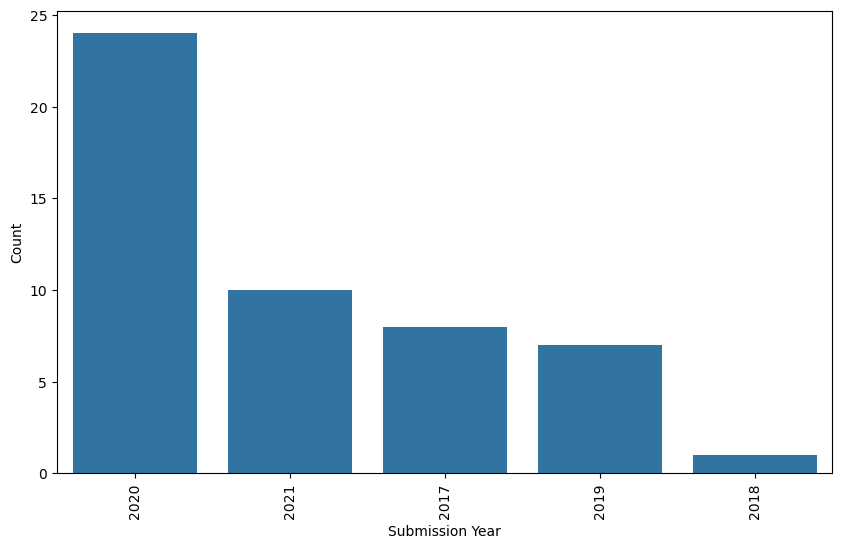

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

print(openalex_df.head())
plt.figure(figsize=(10, 6))
sns.countplot(data=openalex_df, x="SubmissionYear", order=openalex_df["SubmissionYear"].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Submission Year")
plt.ylabel("Count")
plt.show()